<a href="https://colab.research.google.com/github/Adhini99/RETINAL-FUNDUS-SEGMENTATION/blob/main/Copy_of_Retinal_Fundus_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_drive_digital_retinal_images_for_vessel_extraction_path = kagglehub.dataset_download('andrewmvd/drive-digital-retinal-images-for-vessel-extraction')

print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/34_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/40_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/22_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/27_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/28_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/26_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/38_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/39_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images/24_training.tif
/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/tr

Checking training directories:
Contents of /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images: ['34_training.tif', '40_training.tif', '22_training.tif', '27_training.tif', '28_training.tif', '26_training.tif', '38_training.tif', '39_training.tif', '24_training.tif', '33_training.tif', '36_training.tif', '32_training.tif', '25_training.tif', '37_training.tif', '29_training.tif', '23_training.tif', '30_training.tif', '35_training.tif', '31_training.tif', '21_training.tif']
Contents of /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/1st_manual: ['23_manual1.gif', '38_manual1.gif', '35_manual1.gif', '30_manual1.gif', '34_manual1.gif', '27_manual1.gif', '29_manual1.gif', '22_manual1.gif', '25_manual1.gif', '33_manual1.gif', '39_manual1.gif', '36_manual1.gif', '21_manual1.gif', '37_manual1.gif', '24_manual1.gif', '32_manual1.gif', '31_manual1.gif', '40_manual1.gif', '26_manual1.gif', '28_manual1.gif']
Contents of /kaggle/inp

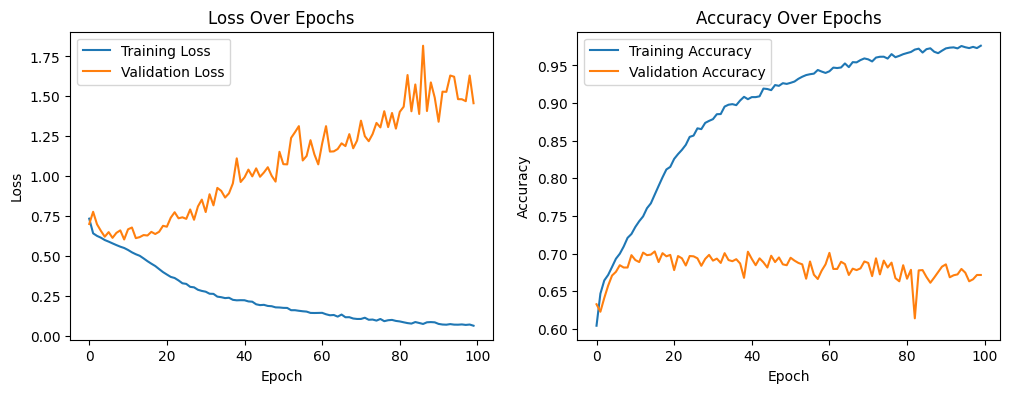

Extracted 883 patches for prediction


/tmp/ipython-input-11-1361874.py:206: RuntimeWarning: invalid value encountered in divide
  pred_mask = np.where(count_mask > 0, pred_mask / count_mask, 0) * 255


Processed 883 patches for prediction, Predicted mask: 688 vessel pixels
Extracted 894 patches for prediction
Processed 894 patches for prediction, Predicted mask: 573 vessel pixels
Extracted 895 patches for prediction


/tmp/ipython-input-11-1361874.py:206: RuntimeWarning: invalid value encountered in divide
  pred_mask = np.where(count_mask > 0, pred_mask / count_mask, 0) * 255


Processed 895 patches for prediction, Predicted mask: 636 vessel pixels
Extracted 893 patches for prediction


/tmp/ipython-input-11-1361874.py:206: RuntimeWarning: invalid value encountered in divide
  pred_mask = np.where(count_mask > 0, pred_mask / count_mask, 0) * 255


Processed 893 patches for prediction, Predicted mask: 674 vessel pixels
Extracted 889 patches for prediction
Processed 889 patches for prediction, Predicted mask: 689 vessel pixels


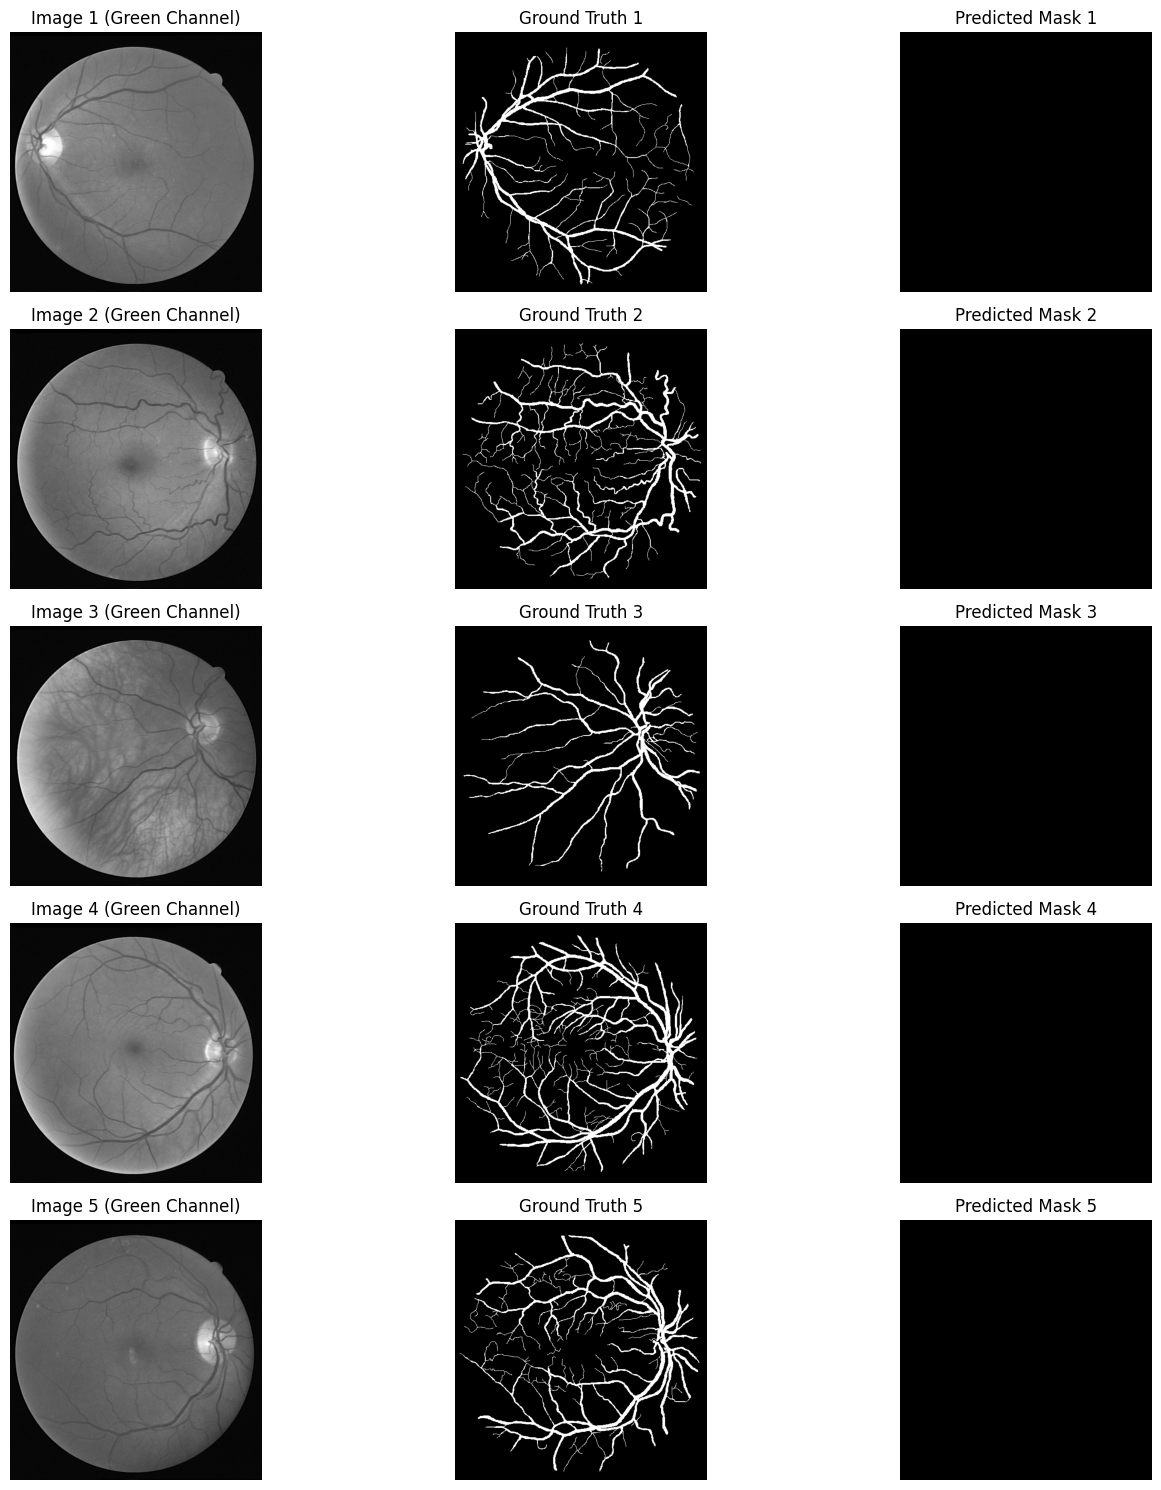

In [ ]:
import os
import numpy as np
from PIL import Image
import cv2
from scipy.ndimage import binary_opening
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Dataset paths
train_images_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images"
train_manual_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/1st_manual"
train_mask_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/mask"
test_images_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/images"
test_mask_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/mask"

# Check directory contents for debugging
def check_directory(path):
    if os.path.exists(path):
        print(f"Contents of {path}: {os.listdir(path)}")
    else:
        print(f"Directory {path} does not exist!")
    return os.path.exists(path)

print("Checking training directories:")
check_directory(train_images_path)
check_directory(train_manual_path)
check_directory(train_mask_path)
print("\nChecking test directories:")
check_directory(test_images_path)
check_directory(test_mask_path)

# Load .tif or .gif image
def load_image(file_path):
    img = Image.open(file_path)
    if img.mode == "RGB":  # For .tif fundus images
        img = np.array(img)
        green_channel = img[:, :, 1]  # Extract green channel
        return green_channel
    else:  # For .gif masks and segmentations (grayscale)
        return np.array(img)

# Preprocessing: GCN, CLAHE, Gamma Correction
def preprocess_image(image):
    mean = np.mean(image)
    std = np.std(image) if np.std(image) != 0 else 1
    gcn_image = (image - mean) / std
    gcn_image = np.clip(gcn_image, 0, 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gcn_image)
    gamma = 1.2
    gamma_image = np.array(255 * (clahe_image / 255) ** (1.0 / gamma), dtype=np.uint8)
    return gamma_image

# Patch Extraction
def extract_patches(image, mask, manual=None, patch_size=64):
    patches = []
    labels = []
    coords = []
    height, width = image.shape
    step = patch_size // 4  # Increased overlap
    pad_size = patch_size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant')
    padded_mask = np.pad(mask, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant')
    padded_manual = np.pad(manual, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant') if manual is not None else None

    for i in range(pad_size, height + pad_size, step):
        for j in range(pad_size, width + pad_size, step):
            if padded_mask[i, j] == 0:
                continue
            patch = padded_image[i - pad_size:i + pad_size, j - pad_size:j + pad_size]
            if patch.shape != (patch_size, patch_size):
                continue
            if manual is not None:
                label = padded_manual[i, j] // 255
                labels.append(label)
            patches.append(patch)
            coords.append((i - pad_size, j - pad_size))

    patches = np.array(patches)
    labels = np.array(labels) if manual is not None else None
    if manual is not None:
        print(f"Extracted {len(patches)} patches: {np.sum(labels == 1)} vessel, {np.sum(labels == 0)} non-vessel")
    else:
        print(f"Extracted {len(patches)} patches for prediction")
    return patches, labels, coords

# Level-I Balancing
def level_i_balancing(patches, labels, rho=0.8):
    if labels is None or len(labels) == 0:
        return patches, labels

    patch_means = np.mean(patches, axis=(1, 2)) / 255.0  # Normalize means to 0-1

    vessel_patches = patches[labels == 1]
    non_vessel_patches = patches[labels == 0]
    non_vessel_means = patch_means[labels == 0]

    num_vessel = len(vessel_patches)
    if num_vessel == 0: # Handle case with no vessel patches
        return patches, labels

    # Adaptive threshold for partial background
    if len(non_vessel_means) > 0:
        threshold = np.percentile(non_vessel_means, 75) # Use 75th percentile for a stricter threshold
    else:
        threshold = 0.5 # Default if no non-vessel patches

    partial_background_indices = np.where(non_vessel_means >= threshold)[0]
    full_background_indices = np.where(non_vessel_means < threshold)[0]

    partial_background = non_vessel_patches[partial_background_indices]
    full_background = non_vessel_patches[full_background_indices]

    num_partial_to_select = int(num_vessel * rho)
    num_full_to_select = int(num_vessel * (1 - rho)) # Balance non-vessel with vessel

    selected_partial_indices = np.random.choice(len(partial_background), min(num_partial_to_select, len(partial_background)), replace=False)
    selected_full_indices = np.random.choice(len(full_background), min(num_full_to_select, len(full_background)), replace=False)

    selected_partial = partial_background[selected_partial_indices]
    selected_full = full_background[selected_full_indices]

    balanced_patches = np.concatenate([vessel_patches, selected_partial, selected_full], axis=0)
    balanced_labels = np.concatenate([
        np.ones(len(vessel_patches)),
        np.zeros(len(selected_partial)),
        np.zeros(len(selected_full))
    ])

    print(f"Balanced dataset: {len(vessel_patches)} vessel, {len(selected_partial)} partial background, {len(selected_full)} full background")
    return balanced_patches, balanced_labels


# Build BLCB-CNN Model
def build_blcb_cnn(input_shape=(64, 64, 1)):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(512),
        BatchNormalization(),
        ReLU(),
        Dropout(0.25),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Post-processing: Morphological Erosion
def postprocess_mask(pred_mask):
    kernel = np.ones((3, 3), np.uint8)
    eroded_mask = cv2.erode(pred_mask, kernel, iterations=1)
    return eroded_mask

# Predict Segmentation Mask for an Image
def predict_mask(model, image, mask, patch_size=64):
    preprocessed_image = preprocess_image(image) * (mask / 255)
    patches, _, coords = extract_patches(preprocessed_image, mask, manual=None)
    patches = patches.reshape(-1, 64, 64, 1)
    pred_patches = model.predict(patches, verbose=0)
    pred_patches = (pred_patches > 0.3).astype(np.uint8).flatten()

    height, width = image.shape
    pred_mask = np.zeros((height, width), dtype=np.float32)
    count_mask = np.zeros((height, width), dtype=np.float32)
    step = patch_size // 4
    idx = 0
    for i in range(0, height, step):
        for j in range(0, width, step):
            if i >= height or j >= width or mask[i, j] == 0:
                continue
            if idx < len(pred_patches):
                pred_mask[i, j] += pred_patches[idx]
                count_mask[i, j] += 1
                idx += 1

    pred_mask = np.where(count_mask > 0, pred_mask / count_mask, 0) * 255
    pred_mask = pred_mask.astype(np.uint8)
    print(f"Processed {idx} patches for prediction, Predicted mask: {np.sum(pred_mask > 0)} vessel pixels")
    return postprocess_mask(pred_mask)

# Data Augmentation
def augment_data(patches, labels):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        cval=0
    )
    augmented_patches = []
    augmented_labels = []

    for patch, label in zip(patches, labels):
        patch = patch.reshape(64, 64, 1)
        augmented_patches.append(patch)
        augmented_labels.append(label)
        for _ in range(2):  # Generate 2 augmented versions per patch
            aug_iter = datagen.flow(patch[np.newaxis, ...], np.array([label]), batch_size=1)
            aug_patch, aug_label = next(aug_iter)
            augmented_patches.append(aug_patch[0])
            augmented_labels.append(aug_label[0])

    return np.array(augmented_patches), np.array(augmented_labels)

# Evaluate Model on Validation Data
def evaluate_model(model, val_patches, val_labels):
    if val_patches is None or val_labels is None:
        print("No validation data available for evaluation.")
        return None, None, None, None

    predictions = model.predict(val_patches, verbose=0)
    thresholds = [0.2, 0.3, 0.4, 0.5]
    best_acc, best_auc, best_sensitivity, best_specificity = 0, 0, 0, 0
    best_threshold = 0.3

    for threshold in thresholds:
        pred_binary = (predictions > threshold).astype(np.uint8).flatten()
        acc = accuracy_score(val_labels, pred_binary)
        auc = roc_auc_score(val_labels, pred_binary)
        tn, fp, fn, tp = confusion_matrix(val_labels, pred_binary).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Threshold {threshold}: Accuracy: {acc:.4f}, AUC: {auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
        if auc > best_auc:
            best_acc, best_auc, best_sensitivity, best_specificity = acc, auc, sensitivity, specificity
            best_threshold = threshold

    print(f"Prediction distribution at threshold {best_threshold}: {np.sum(predictions > best_threshold)} vessel, {np.sum(predictions <= best_threshold)} non-vessel")
    return best_acc, best_auc, best_sensitivity, best_specificity

# Load and Process Training Dataset
def load_dataset(images_path, manual_path, mask_path):
    if not os.path.exists(manual_path):
        print(f"Manual path {manual_path} not found. Skipping dataset loading.")
        return None, None

    all_patches = []
    all_labels = []

    image_files = sorted(os.listdir(images_path))
    manual_files = sorted(os.listdir(manual_path))
    mask_files = sorted(os.listdir(mask_path))

    for idx, (img_file, manual_file, mask_file) in enumerate(zip(image_files, manual_files, mask_files)):
        print(f"Processing image {idx + 1}/{len(image_files)}: {img_file}")
        image = load_image(os.path.join(images_path, img_file))
        mask = load_image(os.path.join(mask_path, mask_file))
        manual = load_image(os.path.join(manual_path, manual_file))

        preprocessed_image = preprocess_image(image)
        preprocessed_image = preprocessed_image * (mask / 255) # Apply mask to preprocessed image

        patches, labels, _ = extract_patches(preprocessed_image, mask, manual)

        # Check if patches or labels are empty after extraction
        if patches is None or labels is None or len(patches) == 0:
            print(f"No valid patches extracted for image {img_file}. Skipping balancing.")
            continue

        balanced_patches, balanced_labels = level_i_balancing(patches, labels)

        all_patches.append(balanced_patches)
        all_labels.append(balanced_labels)

    if not all_patches: # Handle case where no patches were extracted from any image
        print("No patches were loaded from any image. Returning empty arrays.")
        return np.array([]), np.array([])


    all_patches = np.concatenate(all_patches, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    all_patches = all_patches.reshape(-1, 64, 64, 1) # Reshape for CNN input
    print(f"Total dataset: {len(all_patches)} patches, {np.sum(all_labels == 1)} vessel, {np.sum(all_labels == 0)} non-vessel")
    return all_patches, all_labels


# Main Execution
def main():
    # Load training data
    print("Starting dataset loading...")
    train_patches, train_labels = load_dataset(train_images_path, train_manual_path, train_mask_path)
    if train_patches is None:
        print("Training data could not be loaded. Exiting.")
        return

    # Augment data
    train_patches, train_labels = augment_data(train_patches, train_labels)

    # Split training data into training and validation sets
    train_patches, val_patches, train_labels, val_labels = train_test_split(
        train_patches, train_labels, test_size=0.2, random_state=42
    )

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    print(f"Class weights: {class_weight_dict}")

    # Build and train model
    model = build_blcb_cnn()
    history = model.fit(
        train_patches, train_labels,
        batch_size=64, epochs=100,  # Increased epochs
        validation_data=(val_patches, val_labels),
        class_weight=class_weight_dict,
        verbose=1
    )

    # Evaluate model on validation data
    acc, auc, sensitivity, specificity = evaluate_model(model, val_patches, val_labels)
    if acc is not None:
        print(f"Validation Accuracy: {acc:.4f}, AUC: {auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Visualize results for five training images
    image_files = sorted(os.listdir(train_images_path))[:5]
    mask_files = sorted(os.listdir(train_mask_path))[:5]
    manual_files = sorted(os.listdir(train_manual_path))[:5]

    plt.figure(figsize=(15, 15))
    for i, (img_file, mask_file, manual_file) in enumerate(zip(image_files, mask_files, manual_files)):
        image = load_image(os.path.join(train_images_path, img_file))
        mask = load_image(os.path.join(train_mask_path, mask_file))
        manual = load_image(os.path.join(train_manual_path, manual_file))

        pred_mask = predict_mask(model, image, mask)

        plt.subplot(5, 3, i * 3 + 1)
        plt.title(f"Image {i+1} (Green Channel)")
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        plt.subplot(5, 3, i * 3 + 2)
        plt.title(f"Ground Truth {i+1}")
        plt.imshow(manual, cmap='gray')
        plt.axis('off')

        plt.subplot(5, 3, i * 3 + 3)
        plt.title(f"Predicted Mask {i+1}")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Checking training directories:
Contents of /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images: ['34_training.tif', '40_training.tif', '22_training.tif', '27_training.tif', '28_training.tif', '26_training.tif', '38_training.tif', '39_training.tif', '24_training.tif', '33_training.tif', '36_training.tif', '32_training.tif', '25_training.tif', '37_training.tif', '29_training.tif', '23_training.tif', '30_training.tif', '35_training.tif', '31_training.tif', '21_training.tif']
Contents of /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/1st_manual: ['23_manual1.gif', '38_manual1.gif', '35_manual1.gif', '30_manual1.gif', '34_manual1.gif', '27_manual1.gif', '29_manual1.gif', '22_manual1.gif', '25_manual1.gif', '33_manual1.gif', '39_manual1.gif', '36_manual1.gif', '21_manual1.gif', '37_manual1.gif', '24_manual1.gif', '32_manual1.gif', '31_manual1.gif', '40_manual1.gif', '26_manual1.gif', '28_manual1.gif']
Contents of /kaggle/inp

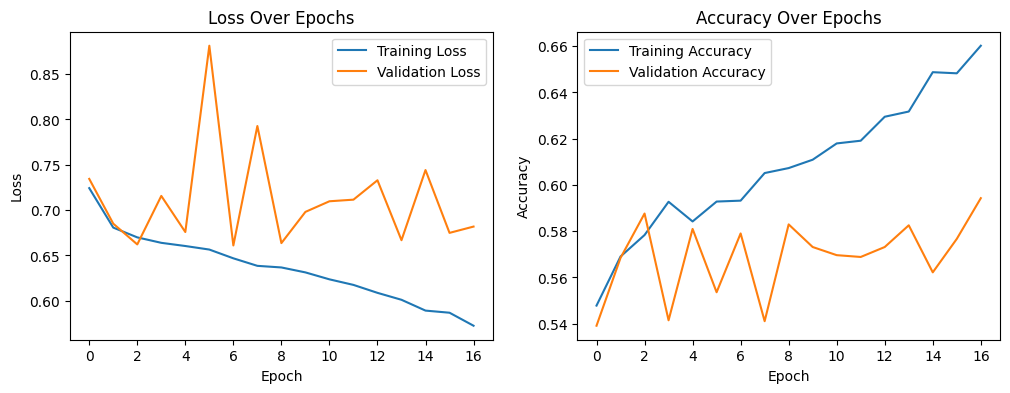

Extracted 883 patches for prediction


/tmp/ipython-input-12-2285883932.py:195: RuntimeWarning: invalid value encountered in divide
  pred_mask = np.where(count_mask > 0, pred_mask / count_mask, 0) * 255


Processed 883 patches for prediction, Predicted mask: 248096 vessel pixels
Extracted 894 patches for prediction
Processed 894 patches for prediction, Predicted mask: 240064 vessel pixels
Extracted 895 patches for prediction


/tmp/ipython-input-12-2285883932.py:195: RuntimeWarning: invalid value encountered in divide
  pred_mask = np.where(count_mask > 0, pred_mask / count_mask, 0) * 255


Processed 895 patches for prediction, Predicted mask: 244800 vessel pixels
Extracted 893 patches for prediction


/tmp/ipython-input-12-2285883932.py:195: RuntimeWarning: invalid value encountered in divide
  pred_mask = np.where(count_mask > 0, pred_mask / count_mask, 0) * 255


Processed 893 patches for prediction, Predicted mask: 245152 vessel pixels
Extracted 889 patches for prediction
Processed 889 patches for prediction, Predicted mask: 250656 vessel pixels


In [ ]:
import os
import numpy as np
from PIL import Image
import cv2
from scipy.ndimage import binary_opening, binary_dilation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Dataset paths
train_images_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images"
train_manual_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/1st_manual"
train_mask_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/mask"
test_images_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/images"
test_mask_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/mask"

# Check directory contents for debugging
def check_directory(path):
    if os.path.exists(path):
        print(f"Contents of {path}: {os.listdir(path)}")
    else:
        print(f"Directory {path} does not exist!")
    return os.path.exists(path)

print("Checking training directories:")
check_directory(train_images_path)
check_directory(train_manual_path)
check_directory(train_mask_path)
print("\nChecking test directories:")
check_directory(test_images_path)
check_directory(test_mask_path)

# Load .tif or .gif image
def load_image(file_path):
    img = Image.open(file_path)
    if img.mode == "RGB":  # For .tif fundus images
        img = np.array(img)
        green_channel = img[:, :, 1]  # Extract green channel
        return green_channel
    else:  # For .gif masks and segmentations (grayscale)
        return np.array(img)

# Preprocessing: GCN, CLAHE, Gamma Correction
def preprocess_image(image):
    mean = np.mean(image)
    std = np.std(image) if np.std(image) != 0 else 1
    gcn_image = (image - mean) / std
    gcn_image = np.clip(gcn_image, 0, 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gcn_image)
    gamma = 1.2
    gamma_image = np.array(255 * (clahe_image / 255) ** (1.0 / gamma), dtype=np.uint8)
    return gamma_image

# Patch Extraction
def extract_patches(image, mask, manual=None, patch_size=64):
    patches = []
    labels = []
    coords = []
    height, width = image.shape
    step = patch_size // 4  # Increased overlap
    pad_size = patch_size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant')
    padded_mask = np.pad(mask, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant')
    padded_manual = np.pad(manual, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant') if manual is not None else None

    for i in range(pad_size, height + pad_size, step):
        for j in range(pad_size, width + pad_size, step):
            if padded_mask[i, j] == 0:
                continue
            patch = padded_image[i - pad_size:i + pad_size, j - pad_size:j + pad_size]
            if patch.shape != (patch_size, patch_size):
                continue
            if manual is not None:
                label = padded_manual[i, j] // 255
                labels.append(label)
            patches.append(patch)
            coords.append((i - pad_size, j - pad_size))

    patches = np.array(patches)
    labels = np.array(labels) if manual is not None else None
    if manual is not None:
        print(f"Extracted {len(patches)} patches: {np.sum(labels == 1)} vessel, {np.sum(labels == 0)} non-vessel")
    else:
        print(f"Extracted {len(patches)} patches for prediction")
    return patches, labels, coords

# Level-I Balancing
def level_i_balancing(patches, labels, threshold=None, rho=0.9):
    patch_means = np.mean(patches, axis=(1, 2)) / 255.0
    vessel_patches = patches[labels == 1]
    non_vessel_patches = patches[labels == 0]
    non_vessel_means = patch_means[labels == 0]

    # Adaptive threshold based on median of non-vessel patch means
    threshold = np.median(non_vessel_means) / 2 if len(non_vessel_means) > 0 else 0.05
    print(f"Adaptive threshold: {threshold:.4f}")

    partial_background = non_vessel_patches[non_vessel_means >= threshold]
    full_background = non_vessel_patches[non_vessel_means < threshold]

    num_vessel = len(vessel_patches)
    num_partial = int(num_vessel * rho)
    num_full = int(num_vessel * (1 - rho))

    empty_patch_array = np.empty((0, 64, 64))
    partial_indices = np.random.choice(len(partial_background), min(num_partial, len(partial_background)), replace=False) if len(partial_background) > 0 else []
    full_indices = np.random.choice(len(full_background), min(num_full, len(full_background)), replace=False) if len(full_background) > 0 else []

    selected_partial = partial_background[partial_indices] if len(partial_indices) > 0 else empty_patch_array
    selected_full = full_background[full_indices] if len(full_indices) > 0 else empty_patch_array

    arrays_to_concat = [vessel_patches]
    if selected_partial.shape[0] > 0:
        arrays_to_concat.append(selected_partial)
    if selected_full.shape[0] > 0:
        arrays_to_concat.append(selected_full)

    balanced_patches = np.concatenate(arrays_to_concat, axis=0) if len(arrays_to_concat) > 1 else vessel_patches
    balanced_labels = np.concatenate([
        np.ones(len(vessel_patches)),
        np.zeros(len(selected_partial) + len(selected_full))
    ]) if len(arrays_to_concat) > 1 else np.ones(len(vessel_patches))

    print(f"Balanced dataset: {len(vessel_patches)} vessel, {len(selected_partial)} partial background, {len(selected_full)} full background")
    return balanced_patches, balanced_labels

# Build BLCB-CNN Model
def build_blcb_cnn(input_shape=(64, 64, 1)):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(512),
        BatchNormalization(),
        ReLU(),
        Dropout(0.25),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Post-processing: Morphological Erosion and Dilation
def postprocess_mask(pred_mask):
    kernel = np.ones((3, 3), np.uint8)
    eroded_mask = cv2.erode(pred_mask, kernel, iterations=1)
    refined_mask = cv2.dilate(eroded_mask, kernel, iterations=1)
    return refined_mask

# Predict Segmentation Mask for an Image
def predict_mask(model, image, mask, patch_size=64):
    preprocessed_image = preprocess_image(image) * (mask / 255)
    patches, _, coords = extract_patches(preprocessed_image, mask, manual=None)
    patches = patches.reshape(-1, 64, 64, 1)
    pred_patches = model.predict(patches, verbose=0)
    pred_patches = (pred_patches > 0.3).astype(np.uint8)

    height, width = image.shape
    pred_mask = np.zeros((height, width), dtype=np.float32)
    count_mask = np.zeros((height, width), dtype=np.float32)

    for idx, (top, left) in enumerate(coords):
        pred_mask[top:top + patch_size, left:left + patch_size] += pred_patches[idx]
        count_mask[top:top + patch_size, left:left + patch_size] += 1

    pred_mask = np.where(count_mask > 0, pred_mask / count_mask, 0) * 255
    pred_mask = pred_mask.astype(np.uint8)
    print(f"Processed {len(patches)} patches for prediction, Predicted mask: {np.sum(pred_mask > 0)} vessel pixels")
    return postprocess_mask(pred_mask)

# Data Augmentation
def augment_data(patches, labels):
    datagen = ImageDataGenerator(
        rotation_range=20,  # Increased intensity
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        cval=0
    )
    augmented_patches = []
    augmented_labels = []

    for patch, label in zip(patches, labels):
        patch = patch.reshape(64, 64, 1)
        augmented_patches.append(patch)
        augmented_labels.append(label)
        for _ in range(2):  # Generate 2 augmented versions per patch
            aug_iter = datagen.flow(patch[np.newaxis, ...], np.array([label]), batch_size=1)
            aug_patch, aug_label = next(aug_iter)
            augmented_patches.append(aug_patch[0])
            augmented_labels.append(aug_label[0])

    return np.array(augmented_patches), np.array(augmented_labels)

# Evaluate Model on Validation Data
def evaluate_model(model, val_patches, val_labels):
    if val_patches is None or val_labels is None:
        print("No validation data available for evaluation.")
        return None, None, None, None

    predictions = model.predict(val_patches, verbose=0)
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    best_acc, best_auc, best_sensitivity, best_specificity = 0, 0, 0, 0
    best_threshold = 0.3

    for threshold in thresholds:
        pred_binary = (predictions > threshold).astype(np.uint8).flatten()
        acc = accuracy_score(val_labels, pred_binary)
        auc = roc_auc_score(val_labels, pred_binary)
        tn, fp, fn, tp = confusion_matrix(val_labels, pred_binary).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Threshold {threshold}: Accuracy: {acc:.4f}, AUC: {auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
        if auc > best_auc:
            best_acc, best_auc, best_sensitivity, best_specificity = acc, auc, sensitivity, specificity
            best_threshold = threshold

    print(f"Prediction distribution at threshold {best_threshold}: {np.sum(predictions > best_threshold)} vessel, {np.sum(predictions <= best_threshold)} non-vessel")
    return best_acc, best_auc, best_sensitivity, best_specificity

# Load and Process Training Dataset
def load_dataset(images_path, manual_path, mask_path):
    if not os.path.exists(manual_path):
        print(f"Manual path {manual_path} not found. Skipping dataset loading.")
        return None, None

    all_patches = []
    all_labels = []

    image_files = sorted(os.listdir(images_path))
    manual_files = sorted(os.listdir(manual_path))
    mask_files = sorted(os.listdir(mask_path))

    for img_file, manual_file, mask_file in zip(image_files, manual_files, mask_files):
        image = load_image(os.path.join(images_path, img_file))
        mask = load_image(os.path.join(mask_path, mask_file))
        manual = load_image(os.path.join(manual_path, manual_file))

        preprocessed_image = preprocess_image(image)
        preprocessed_image = preprocessed_image * (mask / 255)

        patches, labels, _ = extract_patches(preprocessed_image, mask, manual)

        balanced_patches, balanced_labels = level_i_balancing(patches, labels)

        all_patches.append(balanced_patches)
        all_labels.append(balanced_labels)

    all_patches = np.concatenate(all_patches, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    all_patches = all_patches.reshape(-1, 64, 64, 1)
    print(f"Total dataset: {len(all_patches)} patches, {np.sum(all_labels == 1)} vessel, {np.sum(all_labels == 0)} non-vessel")
    return all_patches, all_labels

# Main Execution
def main():
    # Load training data
    train_patches, train_labels = load_dataset(train_images_path, train_manual_path, train_mask_path)
    if train_patches is None:
        print("Training data could not be loaded. Exiting.")
        return

    # Augment data
    train_patches, train_labels = augment_data(train_patches, train_labels)

    # Split training data into training and validation sets
    train_patches, val_patches, train_labels, val_labels = train_test_split(
        train_patches, train_labels, test_size=0.2, random_state=42
    )

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    print(f"Class weights: {class_weight_dict}")

    # Build and train model
    model = build_blcb_cnn()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        train_patches, train_labels,
        batch_size=64, epochs=100,
        validation_data=(val_patches, val_labels),
        class_weight=class_weight_dict,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate model on validation data
    acc, auc, sensitivity, specificity = evaluate_model(model, val_patches, val_labels)
    if acc is not None:
        print(f"Validation Accuracy: {acc:.4f}, AUC: {auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Visualize results for five training images
    image_files = sorted(os.listdir(train_images_path))[:5]
    mask_files = sorted(os.listdir(train_mask_path))[:5]
    manual_files = sorted(os.listdir(train_manual_path))[:5]

    plt.figure(figsize=(15, 15))
    for i, (img_file, mask_file, manual_file) in enumerate(zip(image_files, mask_files, manual_files)):
        image = load_image(os.path.join(train_images_path, img_file))
        mask = load_image(os.path.join(train_mask_path, mask_file))
        manual = load_image(os.path.join(train_manual_path, manual_file))

        pred_mask = predict_mask(model, image, mask)

        plt.subplot(5, 3, i * 3 + 1)
        plt.title(f"Image {i+1} (Green Channel)")
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        plt.subplot(5, 3, i * 3 + 2)
        plt.title(f"Ground Truth {i+1}")
        plt.imshow(manual, cmap='gray')
        plt.axis('off')

        plt.subplot(5, 3, i * 3 + 3)
        plt.title(f"Predicted Mask {i+1}")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Checking training directories:
Contents of /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images: ['34_training.tif', '40_training.tif', '22_training.tif', '27_training.tif', '28_training.tif', '26_training.tif', '38_training.tif', '39_training.tif', '24_training.tif', '33_training.tif', '36_training.tif', '32_training.tif', '25_training.tif', '37_training.tif', '29_training.tif', '23_training.tif', '30_training.tif', '35_training.tif', '31_training.tif', '21_training.tif']
Contents of /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/1st_manual: ['23_manual1.gif', '38_manual1.gif', '35_manual1.gif', '30_manual1.gif', '34_manual1.gif', '27_manual1.gif', '29_manual1.gif', '22_manual1.gif', '25_manual1.gif', '33_manual1.gif', '39_manual1.gif', '36_manual1.gif', '21_manual1.gif', '37_manual1.gif', '24_manual1.gif', '32_manual1.gif', '31_manual1.gif', '40_manual1.gif', '26_manual1.gif', '28_manual1.gif']
Contents of /kaggle/inp

Generating predicted mask for image 1/5: 21_training.tif
Extracted 218 patches for prediction


/tmp/ipython-input-13-328224302.py:197: RuntimeWarning: invalid value encountered in divide
  pred_mask = np.where(count_mask > 0, pred_mask / count_mask, 0) * 255


Processed 218 patches for prediction, Predicted mask: 121030 vessel pixels
Generating predicted mask for image 2/5: 22_training.tif
Extracted 222 patches for prediction


/tmp/ipython-input-13-328224302.py:197: RuntimeWarning: invalid value encountered in divide
  pred_mask = np.where(count_mask > 0, pred_mask / count_mask, 0) * 255


Processed 222 patches for prediction, Predicted mask: 156324 vessel pixels
Generating predicted mask for image 3/5: 23_training.tif
Extracted 224 patches for prediction
Processed 224 patches for prediction, Predicted mask: 157089 vessel pixels
Generating predicted mask for image 4/5: 24_training.tif
Extracted 218 patches for prediction
Processed 218 patches for prediction, Predicted mask: 93821 vessel pixels
Generating predicted mask for image 5/5: 25_training.tif
Extracted 218 patches for prediction


/tmp/ipython-input-13-328224302.py:197: RuntimeWarning: invalid value encountered in divide
  pred_mask = np.where(count_mask > 0, pred_mask / count_mask, 0) * 255


Processed 218 patches for prediction, Predicted mask: 128683 vessel pixels


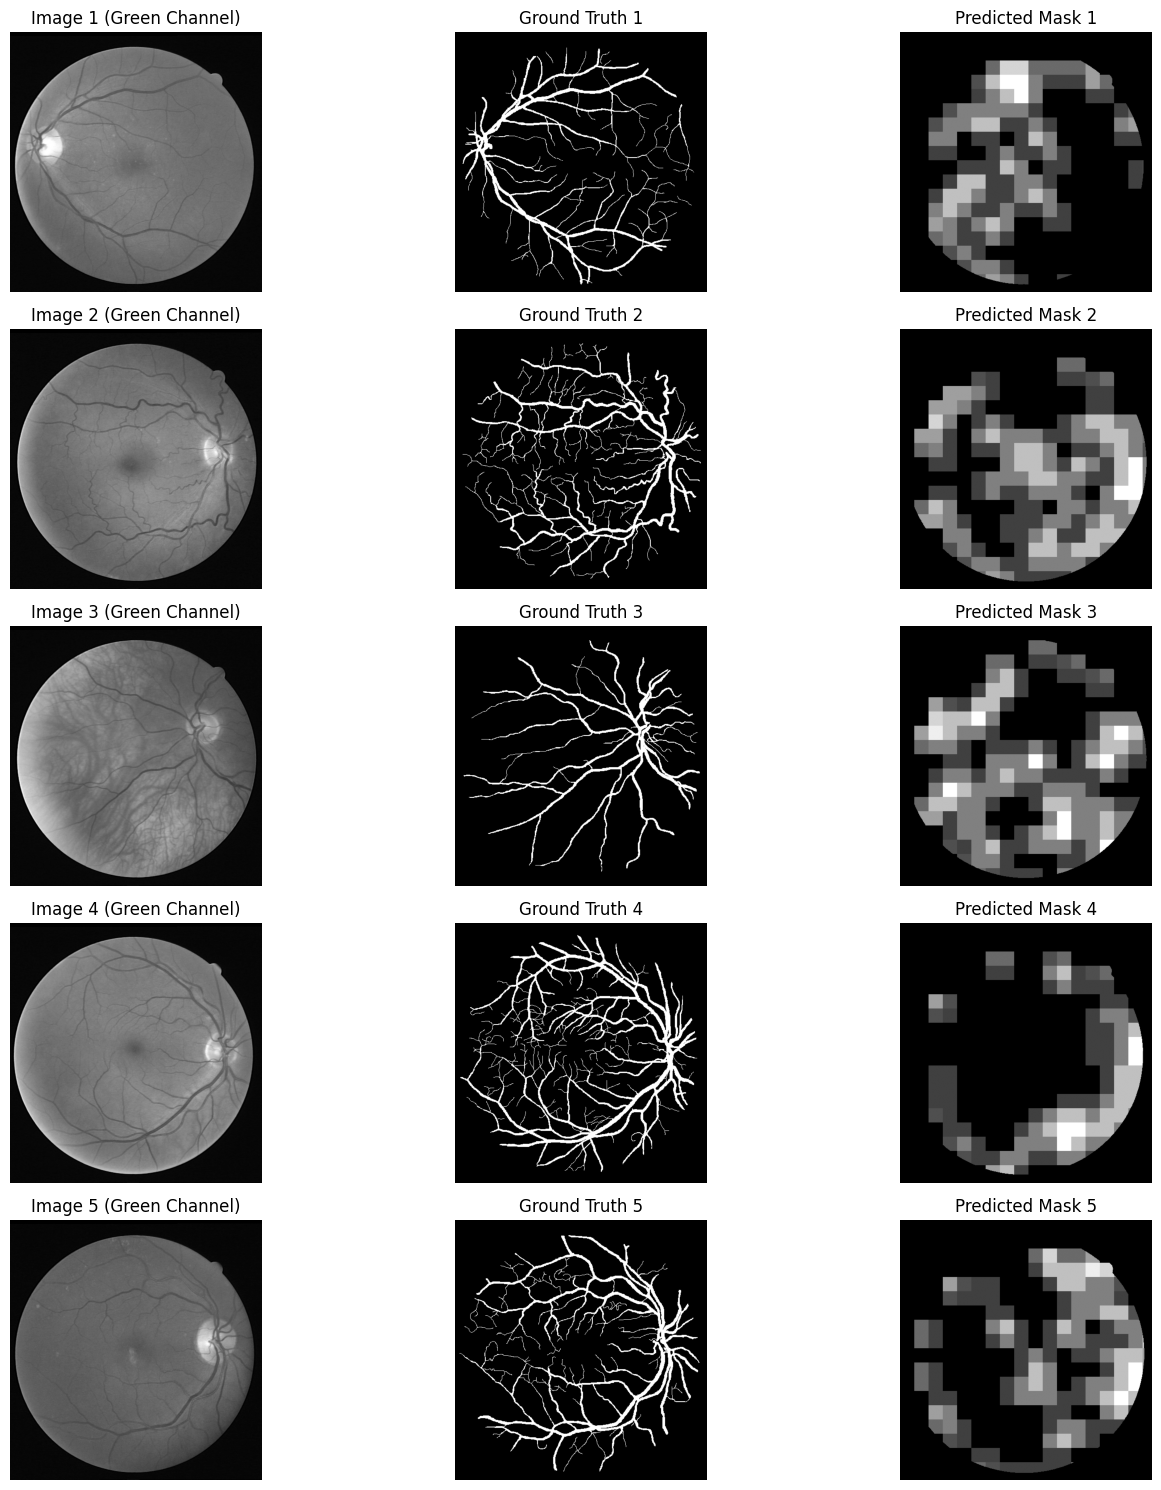

In [ ]:
import os
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Dataset paths
train_images_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images"
train_manual_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/1st_manual"
train_mask_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/mask"
test_images_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/images"
test_mask_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/mask"

# Check directory contents for debugging
def check_directory(path):
    if os.path.exists(path):
        print(f"Contents of {path}: {os.listdir(path)}")
    else:
        print(f"Directory {path} does not exist!")
    return os.path.exists(path)

print("Checking training directories:")
check_directory(train_images_path)
check_directory(train_manual_path)
check_directory(train_mask_path)
print("\nChecking test directories:")
check_directory(test_images_path)
check_directory(test_mask_path)

# Load .tif or .gif image
def load_image(file_path):
    img = Image.open(file_path)
    if img.mode == "RGB":  # For .tif fundus images
        img = np.array(img)
        green_channel = img[:, :, 1]  # Extract green channel
        return green_channel
    else:  # For .gif masks and segmentations (grayscale)
        return np.array(img)

# Preprocessing: GCN, CLAHE, Gamma Correction
def preprocess_image(image):
    mean = np.mean(image)
    std = np.std(image) if np.std(image) != 0 else 1
    gcn_image = (image - mean) / std
    gcn_image = np.clip(gcn_image, 0, 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gcn_image)
    gamma = 1.2
    gamma_image = np.array(255 * (clahe_image / 255) ** (1.0 / gamma), dtype=np.uint8)
    return gamma_image

# Patch Extraction
def extract_patches(image, mask, manual=None, patch_size=64):
    patches = []
    labels = []
    coords = []
    height, width = image.shape
    step = patch_size // 2  # Step=32 for faster processing
    pad_size = patch_size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant')
    padded_mask = np.pad(mask, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant')
    padded_manual = np.pad(manual, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant') if manual is not None else None

    for i in range(pad_size, height + pad_size, step):
        for j in range(pad_size, width + pad_size, step):
            if padded_mask[i, j] == 0:
                continue
            patch = padded_image[i - pad_size:i + pad_size, j - pad_size:j + pad_size]
            if patch.shape != (patch_size, patch_size):
                continue
            if manual is not None:
                label = padded_manual[i, j] // 255
                labels.append(label)
            patches.append(patch)
            coords.append((i - pad_size, j - pad_size))

    patches = np.array(patches)
    labels = np.array(labels) if manual is not None else None
    if manual is not None:
        print(f"Extracted {len(patches)} patches: {np.sum(labels == 1)} vessel, {np.sum(labels == 0)} non-vessel")
    else:
        print(f"Extracted {len(patches)} patches for prediction")
    return patches, labels, coords

# Level-I Balancing
def level_i_balancing(patches, labels, threshold=None, rho=0.8):
    patch_means = np.mean(patches, axis=(1, 2)) / 255.0
    vessel_patches = patches[labels == 1]
    non_vessel_patches = patches[labels == 0]
    non_vessel_means = patch_means[labels == 0]

    # Adaptive threshold
    threshold = np.median(non_vessel_means) / 2 if len(non_vessel_means) > 0 else 0.01
    print(f"Adaptive threshold: {threshold:.4f}")

    partial_background = non_vessel_patches[non_vessel_means >= threshold]
    full_background = non_vessel_patches[non_vessel_means < threshold]

    num_vessel = len(vessel_patches)
    num_partial = int(num_vessel * rho)
    num_full = int(num_vessel * 3 * (1 - rho))  # Increase full background

    empty_patch_array = np.empty((0, 64, 64))
    partial_indices = np.random.choice(len(partial_background), min(num_partial, len(partial_background)), replace=False) if len(partial_background) > 0 else []
    full_indices = np.random.choice(len(full_background), min(num_full, len(full_background)), replace=False) if len(full_background) > 0 else []

    selected_partial = partial_background[partial_indices] if len(partial_indices) > 0 else empty_patch_array
    selected_full = full_background[full_indices] if len(full_indices) > 0 else empty_patch_array

    arrays_to_concat = [vessel_patches]
    if selected_partial.shape[0] > 0:
        arrays_to_concat.append(selected_partial)
    if selected_full.shape[0] > 0:
        arrays_to_concat.append(selected_full)

    balanced_patches = np.concatenate(arrays_to_concat, axis=0) if len(arrays_to_concat) > 1 else vessel_patches
    balanced_labels = np.concatenate([
        np.ones(len(vessel_patches)),
        np.zeros(len(selected_partial) + len(selected_full))
    ]) if len(arrays_to_concat) > 1 else np.ones(len(vessel_patches))

    print(f"Balanced dataset: {len(vessel_patches)} vessel, {len(selected_partial)} partial background, {len(selected_full)} full background")
    return balanced_patches, balanced_labels

# Build BLCB-CNN Model
def build_blcb_cnn(input_shape=(64, 64, 1)):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(512),
        BatchNormalization(),
        ReLU(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Post-processing: Morphological Closing
def postprocess_mask(pred_mask, mask):
    kernel = np.ones((3, 3), np.uint8)
    closed_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    return closed_mask * (mask // 255)  # Restrict to FOV

# Predict Segmentation Mask for an Image
def predict_mask(model, image, mask, patch_size=64):
    preprocessed_image = preprocess_image(image) * (mask / 255)
    patches, _, coords = extract_patches(preprocessed_image, mask, manual=None)
    patches = patches.reshape(-1, 64, 64, 1)
    pred_patches = model.predict(patches, verbose=0)
    pred_patches = (pred_patches > 0.5).astype(np.uint8).flatten()

    height, width = image.shape
    pred_mask = np.zeros((height, width), dtype=np.float32)
    count_mask = np.zeros((height, width), dtype=np.float32)
    count_mask += (mask / 255)  # Initialize with mask to avoid zeros

    for idx, (top, left) in enumerate(coords):
        top_end = min(top + patch_size, height)
        left_end = min(left + patch_size, width)
        patch_height = top_end - top
        patch_width = left_end - left
        pred_value = pred_patches[idx]
        pred_mask[top:top_end, left:left_end] += pred_value
        count_mask[top:top_end, left:left_end] += 1

    pred_mask = np.where(count_mask > 0, pred_mask / count_mask, 0) * 255
    pred_mask = pred_mask.astype(np.uint8) * (mask // 255)
    print(f"Processed {len(patches)} patches for prediction, Predicted mask: {np.sum(pred_mask > 0)} vessel pixels")
    return postprocess_mask(pred_mask, mask)

# Evaluate Model on Validation Data
def evaluate_model(model, val_patches, val_labels):
    if val_patches is None or val_labels is None:
        print("No validation data available for evaluation.")
        return None, None, None, None

    predictions = model.predict(val_patches, verbose=0)
    thresholds = [0.35, 0.4, 0.45, 0.5]
    best_acc, best_auc, best_sensitivity, best_specificity = 0, 0, 0, 0
    best_threshold = 0.5

    for threshold in thresholds:
        pred_binary = (predictions > threshold).astype(np.uint8).flatten()
        acc = accuracy_score(val_labels, pred_binary)
        auc = roc_auc_score(val_labels, pred_binary)
        tn, fp, fn, tp = confusion_matrix(val_labels, pred_binary).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Threshold {threshold}: Accuracy: {acc:.4f}, AUC: {auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
        if auc > best_auc:
            best_acc, best_auc, best_sensitivity, best_specificity = acc, auc, sensitivity, specificity
            best_threshold = threshold

    print(f"Prediction distribution at threshold {best_threshold}: {np.sum(predictions > best_threshold)} vessel, {np.sum(predictions <= best_threshold)} non-vessel")
    return best_acc, best_auc, best_sensitivity, best_specificity

# Load and Process Training Dataset
def load_dataset(images_path, manual_path, mask_path):
    if not os.path.exists(manual_path):
        print(f"Manual path {manual_path} not found. Skipping dataset loading.")
        return None, None

    all_patches = []
    all_labels = []

    image_files = sorted(os.listdir(images_path))
    manual_files = sorted(os.listdir(manual_path))
    mask_files = sorted(os.listdir(mask_path))

    for idx, (img_file, manual_file, mask_file) in enumerate(zip(image_files, manual_files, mask_files)):
        print(f"Processing image {idx + 1}/{len(image_files)}: {img_file}")
        image = load_image(os.path.join(images_path, img_file))
        mask = load_image(os.path.join(mask_path, mask_file))
        manual = load_image(os.path.join(manual_path, manual_file))

        preprocessed_image = preprocess_image(image)
        preprocessed_image = preprocessed_image * (mask / 255)

        patches, labels, _ = extract_patches(preprocessed_image, mask, manual)

        balanced_patches, balanced_labels = level_i_balancing(patches, labels)

        all_patches.append(balanced_patches)
        all_labels.append(balanced_labels)

    all_patches = np.concatenate(all_patches, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    all_patches = all_patches.reshape(-1, 64, 64, 1)
    print(f"Total dataset: {len(all_patches)} patches, {np.sum(all_labels == 1)} vessel, {np.sum(all_labels == 0)} non-vessel")
    return all_patches, all_labels

# Main Execution
def main():
    # Load training data
    print("Starting dataset loading...")
    train_patches, train_labels = load_dataset(train_images_path, train_manual_path, train_mask_path)
    if train_patches is None:
        print("Training data could not be loaded. Exiting.")
        return

    # Split training data into training and validation sets
    train_patches, val_patches, train_labels, val_labels = train_test_split(
        train_patches, train_labels, test_size=0.2, random_state=42
    )

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    print(f"Class weights: {class_weight_dict}")

    # Build and train model
    model = build_blcb_cnn()
    print("Starting model training...")
    history = model.fit(
        train_patches, train_labels,
        batch_size=32,
        epochs=100,  # Reduced epochs
        validation_data=(val_patches, val_labels),
        class_weight=class_weight_dict,
        verbose=2  # Per-epoch updates
    )

    # Evaluate model on validation data
    print("Evaluating model...")
    acc, auc, sensitivity, specificity = evaluate_model(model, val_patches, val_labels)
    if acc is not None:
        print(f"Validation Accuracy: {acc:.4f}, AUC: {auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Visualize results for five training images
    image_files = sorted(os.listdir(train_images_path))[:5]
    mask_files = sorted(os.listdir(train_mask_path))[:5]
    manual_files = sorted(os.listdir(train_manual_path))[:5]

    plt.figure(figsize=(15, 15))
    for i, (img_file, mask_file, manual_file) in enumerate(zip(image_files, mask_files, manual_files)):
        print(f"Generating predicted mask for image {i + 1}/5: {img_file}")
        image = load_image(os.path.join(train_images_path, img_file))
        mask = load_image(os.path.join(train_mask_path, mask_file))
        manual = load_image(os.path.join(train_manual_path, manual_file))

        pred_mask = predict_mask(model, image, mask)

        plt.subplot(5, 3, i * 3 + 1)
        plt.title(f"Image {i+1} (Green Channel)")
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        plt.subplot(5, 3, i * 3 + 2)
        plt.title(f"Ground Truth {i+1}")
        plt.imshow(manual, cmap='gray')
        plt.axis('off')

        plt.subplot(5, 3, i * 3 + 3)
        plt.title(f"Predicted Mask {i+1}")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Checking training directories:
Contents of /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images: ['34_training.tif', '40_training.tif', '22_training.tif', '27_training.tif', '28_training.tif', '26_training.tif', '38_training.tif', '39_training.tif', '24_training.tif', '33_training.tif', '36_training.tif', '32_training.tif', '25_training.tif', '37_training.tif', '29_training.tif', '23_training.tif', '30_training.tif', '35_training.tif', '31_training.tif', '21_training.tif']
Contents of /kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/1st_manual: ['23_manual1.gif', '38_manual1.gif', '35_manual1.gif', '30_manual1.gif', '34_manual1.gif', '27_manual1.gif', '29_manual1.gif', '22_manual1.gif', '25_manual1.gif', '33_manual1.gif', '39_manual1.gif', '36_manual1.gif', '21_manual1.gif', '37_manual1.gif', '24_manual1.gif', '32_manual1.gif', '31_manual1.gif', '40_manual1.gif', '26_manual1.gif', '28_manual1.gif']
Contents of /kaggle/inp

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 - 24s - 216ms/step - accuracy: 0.6599 - loss: 0.7364 - val_accuracy: 0.4989 - val_loss: 1.1254 - learning_rate: 2.0000e-04
Epoch 2/200
110/110 - 3s - 25ms/step - accuracy: 0.7034 - loss: 0.6559 - val_accuracy: 0.6064 - val_loss: 0.7992 - learning_rate: 2.0000e-04
Epoch 3/200
110/110 - 3s - 24ms/step - accuracy: 0.7234 - loss: 0.6176 - val_accuracy: 0.7643 - val_loss: 0.4865 - learning_rate: 2.0000e-04
Epoch 4/200
110/110 - 3s - 31ms/step - accuracy: 0.7277 - loss: 0.6019 - val_accuracy: 0.7803 - val_loss: 0.4674 - learning_rate: 2.0000e-04
Epoch 5/200
110/110 - 3s - 24ms/step - accuracy: 0.7274 - loss: 0.5973 - val_accuracy: 0.7883 - val_loss: 0.4644 - learning_rate: 2.0000e-04
Epoch 6/200
110/110 - 3s - 24ms/step - accuracy: 0.7271 - loss: 0.5870 - val_accuracy: 0.7792 - val_loss: 0.4815 - learning_rate: 2.0000e-04
Epoch 7/200
110/110 - 3s - 23ms/step - accuracy: 0.7400 - loss: 0.5674 - val_accuracy: 0.7849 - val_loss: 0.4751 - learning_rate: 2.0000e-04
Epoch 8/200
110/110 - 3

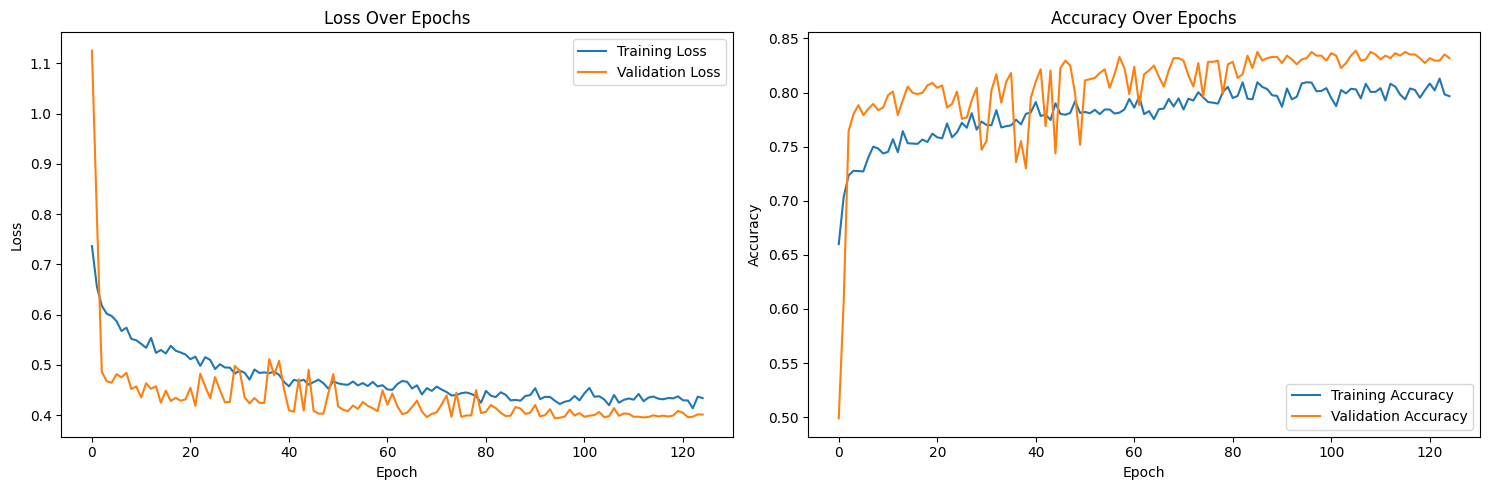

Generating predicted mask for image 1/5: 21_training.tif
Extracted 883 patches for prediction
Processed 883 patches for prediction, Predicted mask: 206578 vessel pixels
Generating predicted mask for image 2/5: 22_training.tif
Extracted 894 patches for prediction
Processed 894 patches for prediction, Predicted mask: 190842 vessel pixels
Generating predicted mask for image 3/5: 23_training.tif
Extracted 895 patches for prediction
Processed 895 patches for prediction, Predicted mask: 203327 vessel pixels
Generating predicted mask for image 4/5: 24_training.tif
Extracted 893 patches for prediction
Processed 893 patches for prediction, Predicted mask: 209503 vessel pixels
Generating predicted mask for image 5/5: 25_training.tif
Extracted 889 patches for prediction
Processed 889 patches for prediction, Predicted mask: 194877 vessel pixels


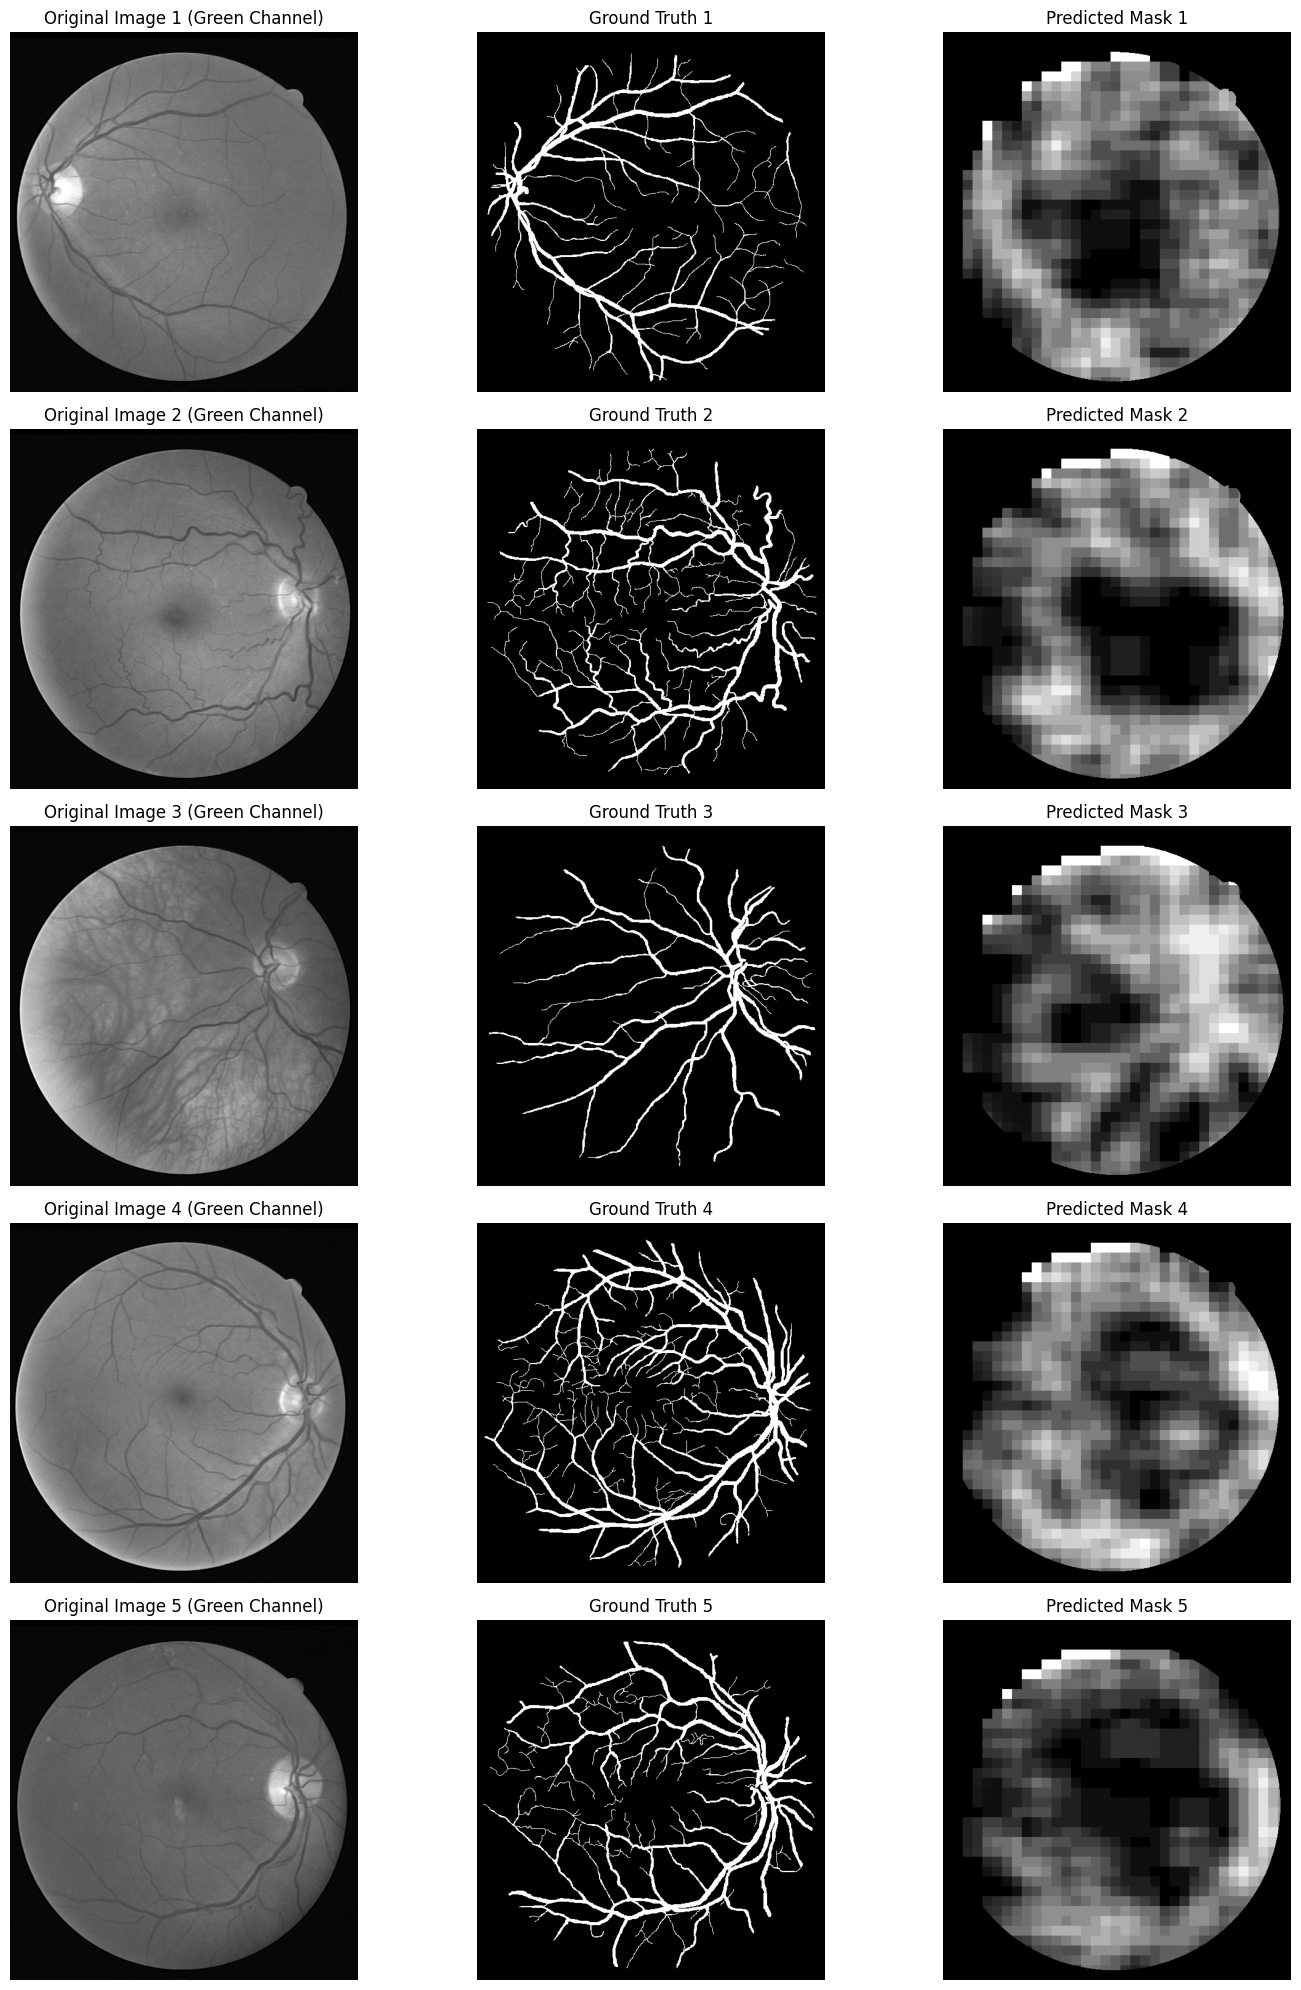

In [ ]:
import os
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score, jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset paths
train_images_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/images"
train_manual_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/1st_manual"
train_mask_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training/mask"
test_images_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/images"
test_mask_path = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE/test/mask"

# Check directory contents for debugging
def check_directory(path):
    if os.path.exists(path):
        print(f"Contents of {path}: {os.listdir(path)}")
    else:
        print(f"Directory {path} does not exist!")
    return os.path.exists(path)

print("Checking training directories:")
check_directory(train_images_path)
check_directory(train_manual_path)
check_directory(train_mask_path)
print("\nChecking test directories:")
check_directory(test_images_path)
check_directory(test_mask_path)

# Load .tif or .gif image
def load_image(file_path):
    img = Image.open(file_path)
    if img.mode == "RGB":  # For .tif fundus images
        img = np.array(img)
        green_channel = img[:, :, 1]  # Extract green channel
        return green_channel
    else:  # For .gif masks and segmentations (grayscale)
        return np.array(img)

# Preprocessing: GCN, CLAHE, Gamma Correction
def preprocess_image(image):
    # Ensure image is float for calculations
    image_float = image.astype(np.float32)

    # GCN
    mean = np.mean(image_float)
    std = np.std(image_float) if np.std(image_float) != 0 else 1
    gcn_image = (image_float - mean) / std

    # Scale to 0-255 and convert to uint8 before CLAHE
    gcn_image = np.clip(gcn_image, -3, 3) # Clip outliers
    gcn_image = ((gcn_image + 3) / 6 * 255).astype(np.uint8) # Scale to 0-255

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gcn_image)

    # Gamma Correction
    gamma = 1.2
    gamma_image = np.array(255 * (clahe_image / 255.0) ** (1.0 / gamma), dtype=np.uint8)
    return gamma_image

# Patch Extraction
def extract_patches(image, mask, manual=None, patch_size=64):
    patches = []
    labels = []
    coords = []
    height, width = image.shape
    step = patch_size // 4  # Smaller step (e.g., 16) for more overlapping patches
    pad_size = patch_size // 2

    # Pad images to handle border cases and ensure full patch extraction
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant')
    padded_mask = np.pad(mask, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant')
    padded_manual = np.pad(manual, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant') if manual is not None else None

    for i in range(pad_size, height + pad_size, step):
        for j in range(pad_size, width + pad_size, step):
            # Check if the center of the patch is within the valid mask region
            if padded_mask[i, j] == 0:
                continue

            patch = padded_image[i - pad_size:i + pad_size, j - pad_size:j + pad_size]

            # Ensure the patch has the desired shape (should be guaranteed by padding and loop range)
            if patch.shape != (patch_size, patch_size):
                continue

            if manual is not None:
                # Label is taken from the center pixel of the manual segmentation
                label = padded_manual[i, j] // 255
                labels.append(label)
            patches.append(patch)
            coords.append((i - pad_size, j - pad_size))

    patches = np.array(patches)
    labels = np.array(labels) if manual is not None else None

    if manual is not None:
        print(f"Extracted {len(patches)} patches: {np.sum(labels == 1)} vessel, {np.sum(labels == 0)} non-vessel")
    else:
        print(f"Extracted {len(patches)} patches for prediction")
    return patches, labels, coords

# Level-I Balancing
def level_i_balancing(patches, labels, rho=0.8):
    if labels is None or len(labels) == 0:
        return patches, labels

    patch_means = np.mean(patches, axis=(1, 2)) / 255.0  # Normalize means to 0-1

    vessel_patches = patches[labels == 1]
    non_vessel_patches = patches[labels == 0]
    non_vessel_means = patch_means[labels == 0]

    num_vessel = len(vessel_patches)
    if num_vessel == 0: # Handle case with no vessel patches
        return patches, labels

    # Adaptive threshold for partial background
    if len(non_vessel_means) > 0:
        threshold = np.percentile(non_vessel_means, 75) # Use 75th percentile for a stricter threshold
    else:
        threshold = 0.5 # Default if no non-vessel patches

    partial_background_indices = np.where(non_vessel_means >= threshold)[0]
    full_background_indices = np.where(non_vessel_means < threshold)[0]

    partial_background = non_vessel_patches[partial_background_indices]
    full_background = non_vessel_patches[full_background_indices]

    num_partial_to_select = int(num_vessel * rho)
    num_full_to_select = int(num_vessel * (1 - rho)) # Balance non-vessel with vessel

    selected_partial_indices = np.random.choice(len(partial_background), min(num_partial_to_select, len(partial_background)), replace=False)
    selected_full_indices = np.random.choice(len(full_background), min(num_full_to_select, len(full_background)), replace=False)

    selected_partial = partial_background[selected_partial_indices]
    selected_full = full_background[selected_full_indices]

    balanced_patches = np.concatenate([vessel_patches, selected_partial, selected_full], axis=0)
    balanced_labels = np.concatenate([
        np.ones(len(vessel_patches)),
        np.zeros(len(selected_partial)),
        np.zeros(len(selected_full))
    ])

    print(f"Balanced dataset: {len(vessel_patches)} vessel, {len(selected_partial)} partial background, {len(selected_full)} full background")
    return balanced_patches, balanced_labels

# Build BLCB-CNN Model
def build_blcb_cnn(input_shape=(64, 64, 1)):
    model = Sequential([
        Input(shape=input_shape),

        # Block 1
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.25), # Slightly increased dropout for first block

        # Block 2
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 3
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.35), # Increased dropout for deeper layers

        # Flatten and Dense layers
        Flatten(),
        Dense(512),
        BatchNormalization(),
        ReLU(),
        Dropout(0.5), # Increased dropout for the dense layer
        Dense(1, activation='sigmoid')
    ])

    # Use a slightly lower initial learning rate
    model.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Post-processing: Morphological Closing
def postprocess_mask(pred_mask, original_mask):
    kernel = np.ones((5, 5), np.uint8) # Slightly larger kernel for closing
    closed_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, kernel, iterations=2) # More iterations

    # Ensure original_mask is binary (0 or 255) and pred_mask is 0-255 for multiplication
    return (closed_mask * (original_mask / 255)).astype(np.uint8)

# Predict Segmentation Mask for an Image
def predict_mask(model, image, mask, patch_size=64):
    preprocessed_image = preprocess_image(image)
    # Apply original mask to preprocessed image to ensure prediction is only within FOV
    preprocessed_image = preprocessed_image * (mask / 255)

    patches, _, coords = extract_patches(preprocessed_image, mask, manual=None, patch_size=patch_size)

    if len(patches) == 0:
        print("No patches extracted for prediction.")
        return np.zeros_like(image, dtype=np.uint8)

    patches = patches.reshape(-1, patch_size, patch_size, 1)

    # Predict probabilities
    pred_probabilities = model.predict(patches, verbose=0).flatten()

    # Use optimal threshold found during validation or a default (e.g., 0.5)
    # For prediction, we might want to be slightly more aggressive to capture more vessels
    prediction_threshold = 0.45 # Can be tuned
    pred_binary = (pred_probabilities > prediction_threshold).astype(np.uint8)

    height, width = image.shape
    pred_mask_accumulator = np.zeros((height, width), dtype=np.float32)
    patch_count_accumulator = np.zeros((height, width), dtype=np.float32)

    for idx, (top, left) in enumerate(coords):
        # Calculate the actual patch boundaries, clipping at image edges
        top_end = min(top + patch_size, height)
        left_end = min(left + patch_size, width)

        # Add the prediction value to the corresponding region in the accumulator
        pred_mask_accumulator[top:top_end, left:left_end] += pred_binary[idx]
        patch_count_accumulator[top:top_end, left:left_end] += 1

    # Avoid division by zero where no patches contributed
    # Use a small epsilon to prevent NaNs or Infs if patch_count_accumulator is zero
    epsilon = 1e-6
    pred_mask_averaged = np.where(patch_count_accumulator > 0,
                                  pred_mask_accumulator / (patch_count_accumulator + epsilon), 0)

    # Convert back to 0-255 scale and apply the original mask to restrict to FOV
    final_pred_mask = (pred_mask_averaged * 255).astype(np.uint8)
    final_pred_mask = final_pred_mask * (mask // 255)

    print(f"Processed {len(patches)} patches for prediction, Predicted mask: {np.sum(final_pred_mask > 0)} vessel pixels")
    return postprocess_mask(final_pred_mask, mask)

# Evaluate Model on Validation Data
def evaluate_model(model, val_patches, val_labels):
    if val_patches is None or val_labels is None or len(val_patches) == 0:
        print("No validation data available for evaluation.")
        return None, None, None, None, None, None

    predictions = model.predict(val_patches, verbose=0).flatten()
    thresholds = np.linspace(0.3, 0.7, 9) # Test a wider range of thresholds

    best_acc, best_auc, best_sensitivity, best_specificity, best_f1, best_iou = 0, 0, 0, 0, 0, 0
    best_threshold = 0.5

    print("\n--- Evaluation Metrics per Threshold ---")
    for threshold in thresholds:
        pred_binary = (predictions > threshold).astype(np.uint8)

        acc = accuracy_score(val_labels, pred_binary)
        auc = roc_auc_score(val_labels, pred_binary)

        # Calculate confusion matrix for sensitivity and specificity
        tn, fp, fn, tp = confusion_matrix(val_labels, pred_binary, labels=[0, 1]).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        f1 = f1_score(val_labels, pred_binary)
        iou = jaccard_score(val_labels, pred_binary)

        print(f"Threshold {threshold:.2f}: Acc: {acc:.4f}, AUC: {auc:.4f}, Sens: {sensitivity:.4f}, Spec: {specificity:.4f}, F1: {f1:.4f}, IoU: {iou:.4f}")

        # Optimize for AUC, or a combination like (AUC + F1) / 2
        current_metric = (auc + f1) / 2 # Using a combined metric for best threshold
        if current_metric > (best_auc + best_f1) / 2:
            best_acc, best_auc, best_sensitivity, best_specificity = acc, auc, sensitivity, specificity
            best_f1, best_iou = f1, iou
            best_threshold = threshold

    print(f"\nOptimal Threshold: {best_threshold:.2f}")
    print(f"Prediction distribution at optimal threshold: {np.sum(predictions > best_threshold)} vessel, {np.sum(predictions <= best_threshold)} non-vessel")
    return best_acc, best_auc, best_sensitivity, best_specificity, best_f1, best_iou

# Load and Process Training Dataset
def load_dataset(images_path, manual_path, mask_path):
    if not os.path.exists(manual_path):
        print(f"Manual path {manual_path} not found. Skipping dataset loading.")
        return None, None

    all_patches = []
    all_labels = []

    image_files = sorted(os.listdir(images_path))
    manual_files = sorted(os.listdir(manual_path))
    mask_files = sorted(os.listdir(mask_path))

    for idx, (img_file, manual_file, mask_file) in enumerate(zip(image_files, manual_files, mask_files)):
        print(f"Processing image {idx + 1}/{len(image_files)}: {img_file}")
        image = load_image(os.path.join(images_path, img_file))
        mask = load_image(os.path.join(mask_path, mask_file))
        manual = load_image(os.path.join(manual_path, manual_file))

        preprocessed_image = preprocess_image(image)
        preprocessed_image = preprocessed_image * (mask / 255) # Apply mask to preprocessed image

        patches, labels, _ = extract_patches(preprocessed_image, mask, manual)

        # Check if patches or labels are empty after extraction
        if patches is None or labels is None or len(patches) == 0:
            print(f"No valid patches extracted for image {img_file}. Skipping balancing.")
            continue

        balanced_patches, balanced_labels = level_i_balancing(patches, labels)

        all_patches.append(balanced_patches)
        all_labels.append(balanced_labels)

    if not all_patches: # Handle case where no patches were extracted from any image
        print("No patches were loaded from any image. Returning empty arrays.")
        return np.array([]), np.array([])

    all_patches = np.concatenate(all_patches, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    all_patches = all_patches.reshape(-1, 64, 64, 1) # Reshape for CNN input
    print(f"Total dataset: {len(all_patches)} patches, {np.sum(all_labels == 1)} vessel, {np.sum(all_labels == 0)} non-vessel")
    return all_patches, all_labels

# Main Execution
def main():
    # Load training data
    print("Starting dataset loading...")
    train_patches, train_labels = load_dataset(train_images_path, train_manual_path, train_mask_path)

    if train_patches is None or len(train_patches) == 0:
        print("Training data could not be loaded or is empty. Exiting.")
        return

    # Split training data into training and validation sets
    train_patches, val_patches, train_labels, val_labels = train_test_split(
        train_patches, train_labels, test_size=0.2, random_state=42, stratify=train_labels # Stratify to maintain class balance in splits
    )

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    print(f"Class weights: {class_weight_dict}")

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,          # Rotate by up to 15 degrees
        width_shift_range=0.1,      # Shift horizontally by up to 10%
        height_shift_range=0.1,     # Shift vertically by up to 10%
        shear_range=0.05,           # Shear transformation
        zoom_range=0.05,            # Zoom in/out
        horizontal_flip=True,       # Randomly flip horizontally
        vertical_flip=True,         # Randomly flip vertically
        fill_mode='nearest'         # Strategy for filling in newly created pixels
    )

    # Fit the data generator on training data (not necessary for ImageDataGenerator.flow)
    # datagen.fit(train_patches) # Not needed if using flow directly

    # Build and train model
    model = build_blcb_cnn()
    print("Starting model training...")

    # Callbacks for learning rate reduction and early stopping
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=0.00001, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1) # Increased patience

    history = model.fit(
        datagen.flow(train_patches, train_labels, batch_size=32), # Use data augmentation
        epochs=200,  # Increased epochs, EarlyStopping will manage it
        validation_data=(val_patches, val_labels),
        class_weight=class_weight_dict,
        callbacks=[reduce_lr, early_stopping], # Add callbacks
        verbose=2  # Per-epoch updates
    )

    # Evaluate model on validation data
    print("\nEvaluating model on validation set...")
    acc, auc, sensitivity, specificity, f1, iou = evaluate_model(model, val_patches, val_labels)
    if acc is not None:
        print(f"\nFinal Validation Metrics (Optimal Threshold):")
        print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, F1-Score: {f1:.4f}, IoU: {iou:.4f}")

    # Plot training history
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Visualize results for five training images
    image_files = sorted(os.listdir(train_images_path))[:5]
    mask_files = sorted(os.listdir(train_mask_path))[:5]
    manual_files = sorted(os.listdir(train_manual_path))[:5]

    plt.figure(figsize=(15, 20)) # Adjusted figure size for better visualization
    for i, (img_file, mask_file, manual_file) in enumerate(zip(image_files, mask_files, manual_files)):
        print(f"Generating predicted mask for image {i + 1}/5: {img_file}")
        image = load_image(os.path.join(train_images_path, img_file))
        mask = load_image(os.path.join(train_mask_path, mask_file))
        manual = load_image(os.path.join(train_manual_path, manual_file))

        pred_mask = predict_mask(model, image, mask)

        plt.subplot(5, 3, i * 3 + 1)
        plt.title(f"Original Image {i+1} (Green Channel)")
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        plt.subplot(5, 3, i * 3 + 2)
        plt.title(f"Ground Truth {i+1}")
        plt.imshow(manual, cmap='gray')
        plt.axis('off')

        plt.subplot(5, 3, i * 3 + 3)
        plt.title(f"Predicted Mask {i+1}")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()